In [1]:
!pip install gdown
!gdown "1KxuQF1xtuPg8g2jsYj1oxaTAQ1zkjoVo" --remaining-ok
!mkdir data
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("data")
%cd "data/detr"

  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=857c6fbd5e67e3020e38c22f438039fa17a5a8b490f9c495dd847a30dcd47709
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1KxuQF1xtuPg8g2jsYj1oxaTAQ1zkjoVo
To: /kaggle/working/data.zip
100%|███████████████████████████████████████| 1.37G/1.37G [00:10<00:00, 137MB/s]
/kaggle/working/data/detr


In [2]:
!pip install pycocotools
import argparse
import random
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import PIL.Image

from models import build_model

from main import get_args_parser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 473.3 kB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370089 sha256=ef5d2cd2713e36e320c4131e467ddafc0a53a35ce7e176292413fd0bb324cc86
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools


In [3]:
parser = argparse.ArgumentParser(description="DETR Args Parser", parents=[get_args_parser()])
args = parser.parse_args(args=[])
args.resume = '/kaggle/working/data/checkpoint.pth'
args.device = 'cpu'

if args.output_dir:
  Path(args.output_dir).mkdir(parents=True, exist_ok=True)

args.distributed = False

print(args)

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path=None, dataset_file='coco', dec_layers=6, device='cpu', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=300, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=2, output_dir='', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='/kaggle/working/data/checkpoint.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)


In [4]:
model, criterion, postprocessors = build_model(args)

device = torch.device(args.device)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [5]:
# Download and load pretrained model weights
output_dir = Path(args.output_dir)
if args.resume:
  checkpoint = torch.load(args.resume, map_location='cpu')
  model.load_state_dict(checkpoint['model'], strict=True)

In [6]:
CLASSES = [
   'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
   'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
   'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
   'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
   'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
   'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
   'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
   'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
   'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
   'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
   'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
   'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
   'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
   'toothbrush'
]

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# Resize bounding boxes to be full size of the image
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [7]:
def detect(im, model, transform):
  img = transform(im).unsqueeze(0)
  assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'Demo model only supports images up to 1600 on each side.'
  outputs = model(img)
  probas = outputs['pred_logits'].softmax(-1)[0,:,:-1]
  keep = probas.max(-1).values > 0.7
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  return probas[keep], bboxes_scaled

In [8]:
the_image_b = PIL.Image.open("/kaggle/working/data/b.JPG").convert('RGB').resize((1600,800))
scores_b, boxes_b = detect(the_image_b, model, transform)
plot_classes = ['person']

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [9]:
the_image_a = PIL.Image.open("/kaggle/working/data/a.JPG").convert('RGB').resize((1600,800))
scores_a, boxes_a = detect(the_image_a, model, transform)
plot_classes = ['person']

In [10]:
%cd "/kaggle/working/data/LFW_Week5"

/kaggle/working/data/LFW_Week5


In [11]:
import requests
import tarfile
import pickle
import numpy as np
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from typing import List
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras, TensorSpec, dtypes
from tensorflow.data import Dataset, AUTOTUNE

import bz2
from face_recognition.align import AlignDlib

In [12]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class TripletLossLayer(Layer):
  def __init__(self, alpha, **kwargs):
	  self.alpha = alpha
	  super(TripletLossLayer, self).__init__(**kwargs)
  
  def get_config(self):
	  config = super().get_config().copy()
	  config.update({'alpha':self.alpha,})
	  return config
    
  def triplet_loss(self, inputs):
    a, p, n = inputs
    p_dist = K.sum(K.square(a-p), axis=-1)
    n_dist = K.sum(K.square(a-n), axis=-1)
    return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)

  def call(self, inputs):
    loss = self.triplet_loss(inputs)
    self.add_loss(loss)
    return loss

In [13]:
import matplotlib.patches as patches

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
# Input for anchor, positive, and negative images
in_a = Input(shape=(96, 96, 3), name="img_a")
in_p = Input(shape=(96, 96, 3), name="img_p")
in_n = Input(shape=(96, 96, 3), name="img_n")

# create the base model from EfficientNetB0
base_cnn = EfficientNetB0(input_shape=(96, 96, 3), include_top=False)

flatten = layers.Flatten()(base_cnn.output)
dense = layers.Dense(512, activation="relu")(flatten)
dense = layers.BatchNormalization()(dense)
output = layers.Dense(128)(dense)

embedding = Model(base_cnn.input, output, name="Embedding")

# Output the embedding vectors from anchor, positive, and negative images
# The model weights are shared (Triplet network)
emb_a = embedding(in_a)
emb_p = embedding(in_p)
emb_n = embedding(in_n)

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

model = Model([in_a, in_p, in_n], triplet_loss_layer)
model.compile(loss=None, optimizer='adam')
model.summary()

2022-04-26 01:21:20.917811: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_a (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
img_p (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
img_n (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 128)          10016035    img_a[0][0]                      
                             

In [15]:
model.load_weights("/kaggle/working/data/asn6_weights.hdf5")

In [16]:
base_model = model.layers[3]

In [17]:
def embedding_distance(embedding1, embedding2):
  # Return L2 distance
  return np.sum(np.square(embedding1 - embedding2))

In [18]:
import os
landmarks_dir = 'models'
landmarks_path = os.path.join(landmarks_dir, 'landmarks.dat')

In [19]:
alignment = AlignDlib(landmarks_path) # create the face alignment model
augmenter = iaa.Sequential([ # create the image augmenter
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0,1.0)), # blur images with a sigma of 0 to 3.0
    iaa.GammaContrast((0.5, 2.0)), # adjust the image contrast
])

def preprocess_image(img_path="", img_aug=True, face_align=True, alignment=alignment, augmenter=augmenter, target_shape=(96,96)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if face_align and (alignment is not None):
        bb = alignment.getLargestFaceBoundingBox(img) # get face bounding box
        if bb is not None:
            img = alignment.align(target_shape[0], img, bb,
                                  landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
            
    img = img.astype("float32") / 255.0

    if img_aug and (augmenter is not None):
        img = augmenter(images=[img])[0]

    img = cv2.resize(img, target_shape)
    img = np.expand_dims(img,axis = 0)

    return img

In [20]:
%cd "/kaggle/working/data"
file2 = open("embeddings.pkl", 'rb')
embeddings = pickle.load(file2)
file2.close()

/kaggle/working/data


CSV Stuff

In [21]:
import pandas as pd
import os 

In [22]:
id_csv = pd.read_csv("/kaggle/working/data/person_id_name_mapping.csv")
id_lookup = id_csv.to_dict(orient="list")
id_list = id_lookup["person_id"]
name_list = id_lookup["person_name"]
name_lookup = {id_list[i]: name_list[i] for i in range(len(id_list))}
id_lookup = {name_list[i]: id_list[i] for i in range(len(id_list))}
id_lookup['Vikas Reddy'] = 21
print(id_lookup)

{'Karan Agarwal': 1, 'Margeret Akande': 2, 'Garrett Beebe': 3, 'Hardik Bhardwaj': 4, 'Kofi Boateng': 5, 'Tejas Chandakkar': 6, 'Urvi Chauhan': 7, 'Rahul Dagar': 8, 'James Dawkins': 9, 'Parthiv Deb': 10, 'Pranav Dulepet': 11, 'Krisha Gandhi': 12, 'Rishiraj Ghosh': 13, 'Gayatri Gopavajhala': 14, 'Felix Gu': 15, 'Arihant Gupta': 16, 'Brian Jacob': 17, 'Saketh Jakka': 18, 'Kieran Johnston': 19, 'Varun Jonnavithula': 20, 'Vikas Kasi Reddy': 21, 'Adil Kasim': 22, 'Andrew Lee': 23, 'Jiarui Li': 24, 'Erik Lin': 25, 'Spencer Lutz': 26, 'Stephane Mbenga': 27, 'Sahan Metpally': 28, 'Ananya Nagireddy': 29, 'Rishi Pradeep': 30, 'Avik Rao': 31, 'Naomi Rosenbaum': 32, 'Gourav Saigal': 33, 'Austin Cairns Sankanung': 34, 'Sriram Somasundaram Senthil': 35, 'Nandini Shah': 36, 'Nathan Tablang': 37, 'Ishan Tripathi': 38, 'Saatvik Vadlapatla': 39, 'Steven Zhang': 40, 'Vikas Reddy': 21}


In [23]:
best_boxes_a = {}

for box in boxes_a.tolist():
  face = the_image_a.crop(box)
  face.save("temp.png")
  my_embedding = base_model.predict(preprocess_image("temp.png"))
  shortest_distance = min(embeddings, key=lambda x: embedding_distance(my_embedding, x[2]))
  closest_name = str(shortest_distance[0])

  if closest_name in id_lookup:
    closest_id = id_lookup[closest_name]
  else:
    print(f"{closest_name} not in list of IDs")

  if closest_id not in best_boxes_a:
    best_boxes_a[closest_id] = (box, shortest_distance)
  else:
    if shortest_distance < best_boxes_a[closest_id][1]:
      best_boxes_a[closest_id] = (box, shortest_distance)
  
print(best_boxes_a)

2022-04-26 01:21:28.463584: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


{13: ([772.8478393554688, 156.09375, 797.7060546875, 183.2762908935547], ('Rishiraj Ghosh', '/content/drive/Shareddrives/2022 FIRE COML STUDENTS/Spring/Face Photos Dataset/Rishiraj Ghosh/IMG_4782.jpg', array([[-5.15585616e-02, -2.74402164e-02, -3.93821336e-02,
        -9.43300426e-02, -5.87727763e-02,  8.09132382e-02,
        -6.09036759e-02,  1.22104231e-02, -2.60318816e-02,
         5.07515743e-02,  8.91742632e-02,  2.98001692e-02,
        -4.93545868e-02,  1.17658630e-01, -2.78053805e-04,
         2.77407896e-02,  3.64383385e-02,  4.12314869e-02,
         3.54349054e-02,  1.80988424e-02,  4.18719603e-03,
        -1.82132311e-02, -5.91770411e-02, -1.50436824e-02,
         1.79977007e-02, -1.28193885e-01, -7.39714652e-02,
        -8.69940128e-03, -6.90261722e-02,  1.50415093e-01,
        -8.75980686e-03,  2.20015161e-02, -2.72420235e-03,
         3.09187453e-02,  1.87060726e-03, -2.99980678e-02,
         1.50512960e-02,  9.30361357e-03,  5.13554811e-02,
         1.73491426e-02,  3.260

In [24]:
best_boxes_b = {}

for box in boxes_b.tolist():
  face = the_image_b.crop(box)
  face.save("temp.png")
  my_embedding = base_model.predict(preprocess_image("temp.png"))
  shortest_distance = min(embeddings, key=lambda x: embedding_distance(my_embedding, x[2]))
  closest_name = str(shortest_distance[0])

  if closest_name in id_lookup:
    closest_id = id_lookup[closest_name]
  else:
    print(f"{closest_name} not in list of IDs")

  if closest_id not in best_boxes_b:
    best_boxes_b[closest_id] = (box, shortest_distance)
  else:
    if shortest_distance < best_boxes_b[closest_id][1]:
      best_boxes_b[closest_id] = (box, shortest_distance)
  
print(best_boxes_b)

{17: ([785.902099609375, 130.38253784179688, 819.700927734375, 169.75204467773438], ('Brian Jacob', '/content/drive/Shareddrives/2022 FIRE COML STUDENTS/Spring/Face Photos Dataset/Brian Jacob/silly.jpg', array([[-0.05453108, -0.03176829, -0.04054125, -0.09618382, -0.06648581,
         0.08699244, -0.06516903,  0.00987581, -0.02726524,  0.05096586,
         0.08846707,  0.02916578, -0.05902966,  0.11267658,  0.00131364,
         0.03213315,  0.03376215,  0.04315409,  0.04144389,  0.02534373,
         0.00511263, -0.02198982, -0.05958878, -0.02299304,  0.02338526,
        -0.12784792, -0.06794363, -0.00517781, -0.06376487,  0.14972296,
        -0.01679135,  0.01848904, -0.00668188,  0.02314225,  0.00410923,
        -0.03706375,  0.01482651,  0.00175787,  0.04785201,  0.0154427 ,
         0.03439708, -0.05127962,  0.02322053,  0.10090356,  0.0497749 ,
         0.00772848,  0.02051817,  0.0389053 ,  0.05077917, -0.0519539 ,
         0.05663792,  0.01110237, -0.03444877,  0.01427278,  0.076

In [25]:
final_df = pd.DataFrame()
final_df["id"] = ["a" + str(i) for i in range(1, 41)] + ["b" + str(i) for i in range(1, 41)]
final_df["xmin"] = 0.0
final_df["xmax"] = 0.0
final_df["ymin"] = 0.0
final_df["ymax"] = 0.0

for person_id in best_boxes_a:
  img_id_str = "a" + str(person_id)
  final_df.loc[final_df["id"] == img_id_str, "xmin"] = best_boxes_a[person_id][0][0]/1600.0 
  final_df.loc[final_df["id"] == img_id_str, "ymin"] = best_boxes_a[person_id][0][1]/800.0
  final_df.loc[final_df["id"] == img_id_str, "xmax"] = best_boxes_a[person_id][0][2]/1600.0 
  final_df.loc[final_df["id"] == img_id_str, "ymax"] = best_boxes_a[person_id][0][3]/800.0

for person_id in best_boxes_b:
  img_id_str = "b" + str(person_id)
  final_df.loc[final_df["id"] == img_id_str, "xmin"] = best_boxes_b[person_id][0][0]/1600.0
  final_df.loc[final_df["id"] == img_id_str, "ymin"] = best_boxes_b[person_id][0][1]/800.0
  final_df.loc[final_df["id"] == img_id_str, "xmax"] = best_boxes_b[person_id][0][2]/1600.0
  final_df.loc[final_df["id"] == img_id_str, "ymax"] = best_boxes_b[person_id][0][3]/800.0

In [26]:
print(len(final_df.index))
final_df = final_df.drop(final_df.index[[1, 9, 12, 41, 49, 52]])
print(len(final_df.index))
final_df.to_csv("/kaggle/working/final_submission.csv", index=False)

80
74


In [27]:
def plot_results(pil_img, boxes):
    plt.figure(figsize=(16,10))
    plt.axis('off')
    ax = plt.gca()
    ax.imshow(pil_img)
    
    for person_id in boxes.keys():
      person_name = name_lookup[person_id]
      (xmin, ymin, xmax, ymax) = boxes[person_id][0]
      xmax = xmax-xmin
      ymax = ymax-ymin
      ax.add_patch(plt.Rectangle((xmin, ymin), xmax, ymax, fill=False, color=[0.850, 0.325, 0.098], linewidth=3))

      ax.text(xmin, ymin, person_name, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))

    # Show the plot
    plt.show()

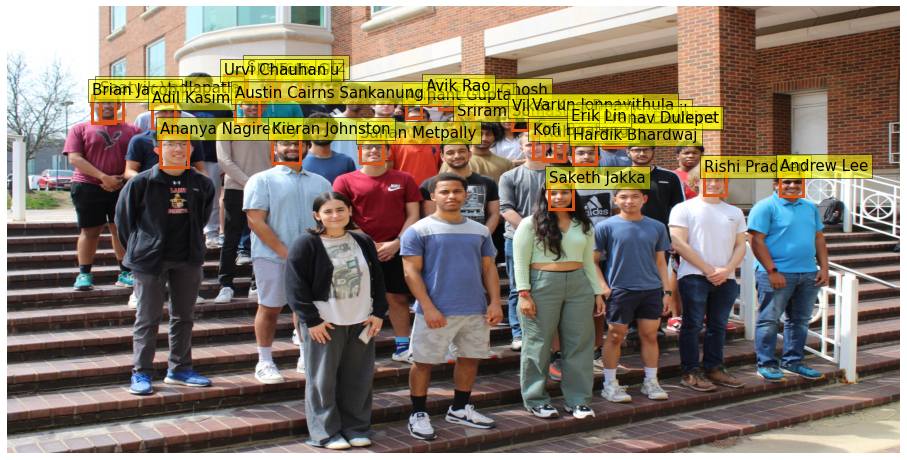

In [28]:
plot_results(the_image_a, best_boxes_a)

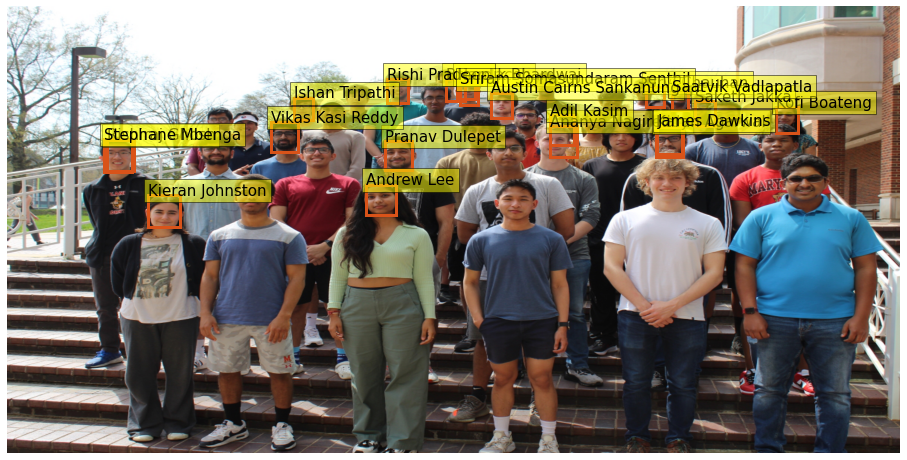

In [29]:
plot_results(the_image_b, best_boxes_b)